In [1]:
import visualID_Eng as vID
vID.init()

**Start at:** Friday 17 June 2022, 17:25:11  
**Hostname:** insa-11357 (Linux)

<p style="text-align: center"><img width="800px" src="./svg/logoPytChem.svg" style="margin-left:auto; margin-right:auto"/></p>

# Prediction of CO<sub>2</sub> solubility with an ANN

<div class="rq">
<b>Reference</b>: 
Z. Song, H. Shi, X. Zhang & T. Zhou (**2020**), Prediction of CO<sub>2</sub> solubility in ionic liquids using machine learning methods, [<i>Chem. Eng. Sci.</i> <b>223</b>: 115752](https://www.doi.org/10.1016/j.ces.2020.115752) 
<br>
<p style="text-align: center"><img width="650px" src="./CO2-images/AbstractANNCO2-SongEtal.png" style="margin-left:auto; margin-right:auto" id="img_AbstractSong"></p>
<br>
The main results are graphically reported below.
<br>
<p style="text-align: center"><img width="1000px" src="./CO2-images/ANNCO2-SongEtal-Results.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>
<br>
<span style="font-weight:bold">The goal of this tutorial is to reproduce the ANN part of this article. </span>
</div>

In [2]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
    
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
import os,sys
from IPython.display import display
    
import numpy as np
import pandas as pd
from IPython.display import display

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   OFF = '\033[0m'

<a id="data-read"></a>
## **1.** Basic data analysis and visualization
The [pandas library](https://pandas.pydata.org/docs/index.html) provides high-performance, easy-to-use data structures and data analysis tools for the Python programming language. It is recommended to first have a look at the [10mn short introduction to pandas](https://pandas.pydata.org/docs/user_guide/10min.html).
### **1.a.** Read the database

In [3]:
dataCO2f='CO2-data'+'/'+'dataCO2.csv'
dataCO2=pd.read_csv(dataCO2f,sep=";",header=0)
display(dataCO2)
# describe() generates descriptive statistics
display(dataCO2.describe().style.format("{0:.2f}"))

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[BMIM][BF4],[BMIM],[BF4],0.610,343.15,188.50,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,[HMIM][Tf2N],[HMIM],[Tf2N],0.592,298.15,35.86,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.33,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.24,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,0.00,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.30,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.51,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.95,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### **1.b.** Any correlation between data?

       x_CO2
[CH3]       
0        855
1       8350
2        108
3         92
4        639
7         72

Duration :  00:00:02 855ms


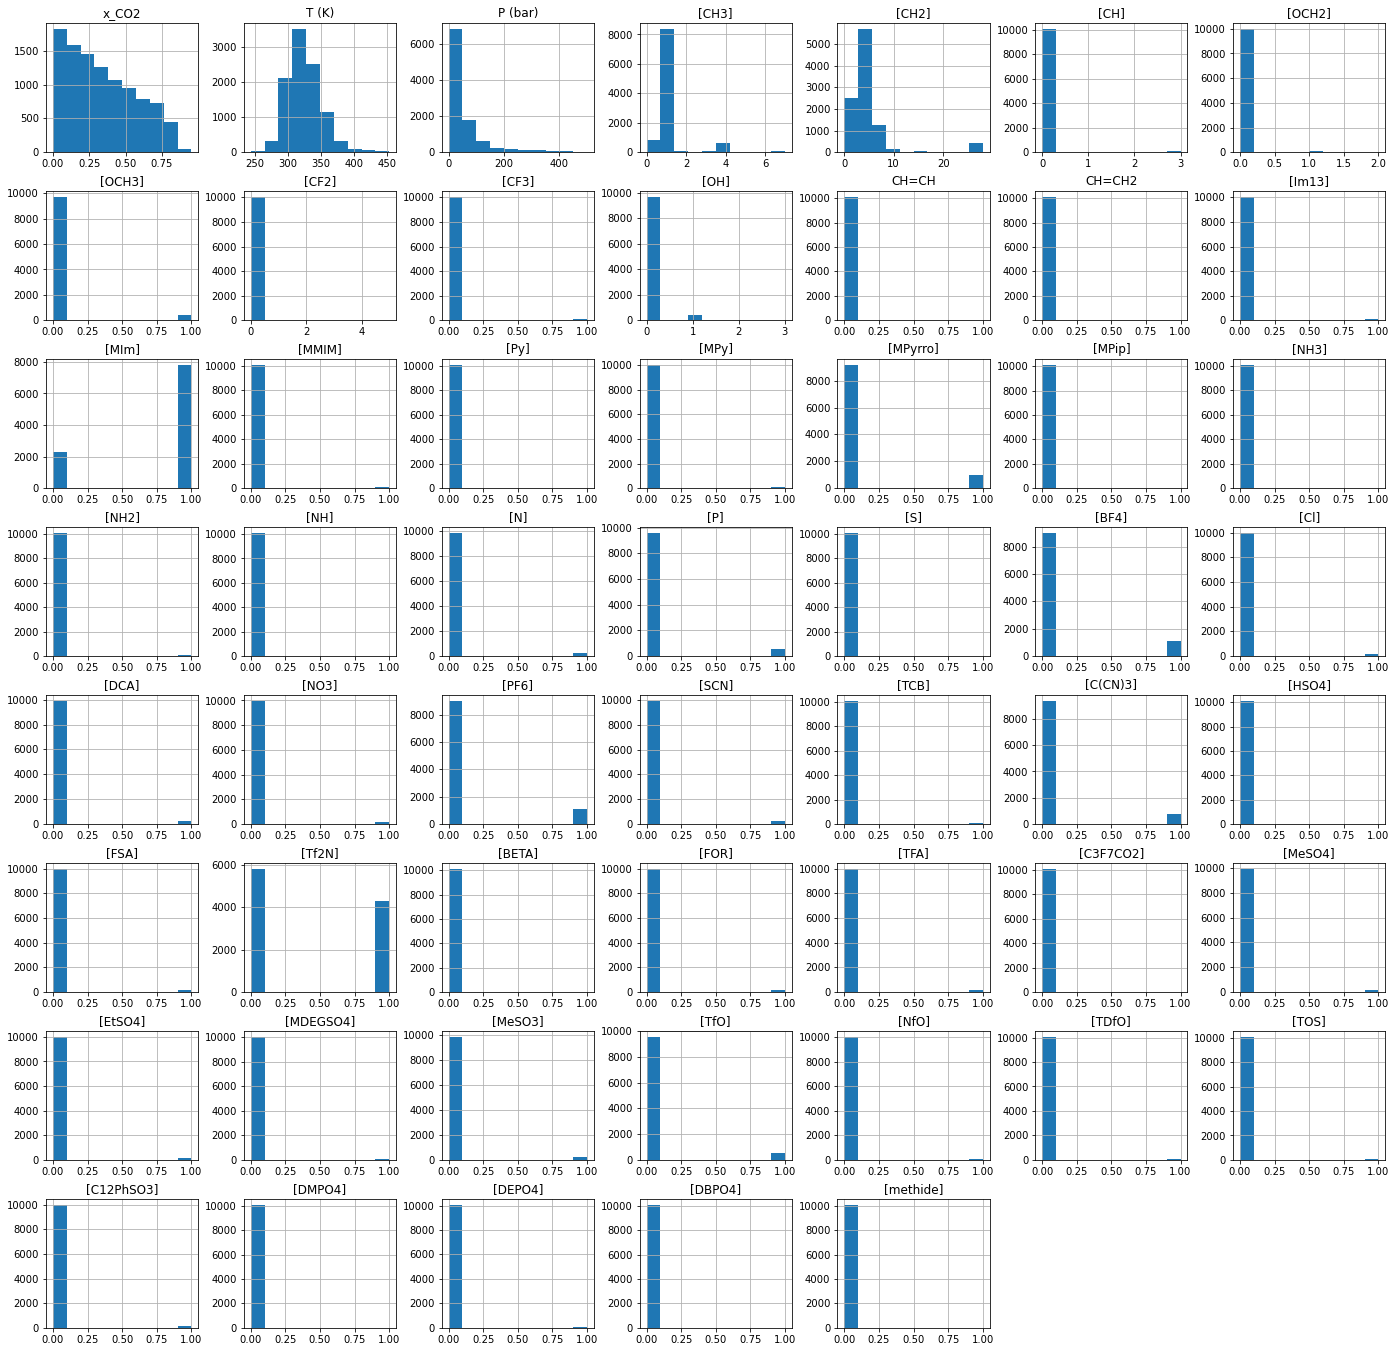

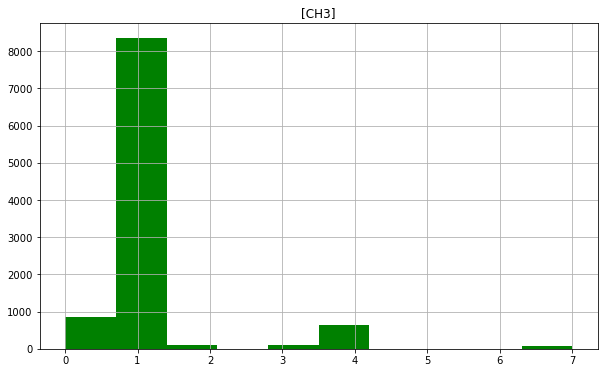

In [4]:
vID.chrono_start()
dataCO2.hist(figsize=(24,24))
print(dataCO2[["x_CO2", "[CH3]"]].groupby("[CH3]").count())
dataCO2.hist("[CH3]",figsize=(10,6),facecolor='g')
vID.chrono_show()

## 2. Prediction of the solubility of CO<sub>2</sub> by deep learning: **minimal python code**

### 2.1. ML scheme of the reference article

<p style="text-align: center"><img width="750px" src="./CO2-images/ANN-CO2Song_etal.png" style="margin-left:auto; margin-right:auto" id="img_Song"></p>

**Methodological details:**
- The MATLAB tansig and purelin transfer functions are employed in the hidden and output layers, respectively
- The experimental data are divided into a training set (8093 points, 80% of the data) to build the model and a test set of the remaining 2023 data points to evaluate the predictive capability of the obtained model
- Instead of performing random selection, we employ a hybrid artificial-random strategy to decompose the dataset. Specifically, the data points consisting of the least frequently used groups are equally divided into five folders

### 2.2. Script 1

Errors calculated between the actual and predicted x_CO2 values (noted $Y$ and $\hat{Y}$ in equations below)  
MAE =  Mean Absolute Error 
$$\mathrm{MAE}=\frac{1}{n}\sum_{i}\left|\hat{Y}(x_{i})-Y(x_{i})\right|$$

MSE = Mean Squared Error  
$$\mathrm{MSE}=\frac{1}{n}\sum_{i}\left(\hat{Y}(x_{i})-Y(x_{i})\right)^{2}$$

In [5]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
data_train = dataCO2.sample(frac=0.8, axis=0, random_state=1)
data_test  = dataCO2.drop(data_train.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']

display(x_train,y_train)
display(x_test,y_test)

#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'
#acthL='relu'
if 'ANNmodel' in globals():
    del ANNmodel
if 'ANNhistory' in globals():
    del ANNhistory
ANNmodel=defANN( (53,), acthL )
ANNmodel.summary()

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
6020,303.15,6.362,1,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6201,363.31,66.750,4,28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8916,323.15,4.940,0,3,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
916,298.15,2.510,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3484,373.15,147.140,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768,343.23,14.790,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4164,301.45,67.000,1,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2410,323.15,70.420,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6278,313.15,11.800,0,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


6020    0.2019
6201    0.6010
8916    0.0677
916     0.0458
3484    0.5700
         ...  
6768    0.2000
4164    0.8120
2410    0.4460
6278    0.1840
9963    0.3540
Name: x_CO2, Length: 8093, dtype: float64

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,363.15,246.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,353.15,223.30,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,383.15,117.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,343.75,104.90,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,333.95,91.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10090,343.15,247.08,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10094,298.15,135.25,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10099,323.15,110.81,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10102,323.15,90.78,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0        0.610
2        0.610
15       0.350
18       0.458
20       0.458
         ...  
10090    0.771
10094    0.822
10099    0.769
10102    0.726
10111    0.592
Name: x_CO2, Length: 2023, dtype: float64

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hLayer (Dense)               (None, 7)                 378       
_________________________________________________________________
oLayer (Dense)               (None, 1)                 8         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


2022-06-17 17:25:36.010703: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-17 17:25:36.010955: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 17:25:36.011732: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [6]:
#######################################################################################
# optimization of the ANN
# library used: keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 20,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ytrain_hat=ANNmodel.predict(x_train)
ytest_hat=ANNmodel.predict(x_test)
diffyt = ytrain_hat.ravel() - y_train.ravel()
diffyp = ytest_hat.ravel() - y_test.ravel()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt),
      "   std: ", np.std(diffyt),
      "   MAE: ", np.average(abs(diffyt)),
      "    R2: ", np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp),
      "   std: ", np.std(diffyp),
      "   MAE: ", np.average(abs(diffyp)),
      "    R2: ", np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1]
     )

#######################################################################################
# save model for later use

#!mkdir -p saved_models
#ANNmodel.save('saved_models/ANNmodel-basic')

2022-06-17 17:25:40.303600: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-17 17:25:40.304078: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099940000 Hz


Epoch 1/200
405/405 [==============================] - 2s 3ms/step - loss: 0.1500 - mae: 0.2840 - mse: 0.1500 - val_loss: 0.0441 - val_mae: 0.1767 - val_mse: 0.0441
Epoch 2/200
405/405 [==============================] - 1s 2ms/step - loss: 0.0446 - mae: 0.1769 - mse: 0.0446 - val_loss: 0.0370 - val_mae: 0.1599 - val_mse: 0.0370
Epoch 3/200
405/405 [==============================] - 1s 2ms/step - loss: 0.0389 - mae: 0.1656 - mse: 0.0389 - val_loss: 0.0299 - val_mae: 0.1369 - val_mse: 0.0299
Epoch 4/200
405/405 [==============================] - 1s 2ms/step - loss: 0.0217 - mae: 0.1161 - mse: 0.0217 - val_loss: 0.0123 - val_mae: 0.0827 - val_mse: 0.0123
Epoch 5/200
405/405 [==============================] - 1s 2ms/step - loss: 0.0126 - mae: 0.0855 - mse: 0.0126 - val_loss: 0.0108 - val_mae: 0.0782 - val_mse: 0.0108
Epoch 6/200
405/405 [==============================] - 1s 2ms/step - loss: 0.0119 - mae: 0.0828 - mse: 0.0119 - val_loss: 0.0102 - val_mae: 0.0769 - val_mse: 0.0102
Epoch 7/20

<div class="warn"><span style="color:red; font-weight:bold">The MAE and R2 parameters seem rather good (<i>ca.</i> 0.07 and 0.92), but this prediction is actually very bad, as you will see by jumping to the <a href="#model-evaluation">Model Evaluation</a> section!</span>
<br>
<br>  
Unless you were lucky (an element of chance is involved in the learning process), the predicted <i>vs.</i> actual CO<sub>2</sub> solubility probably looks like this: 
<br>
<p style="text-align: center"><img width="550px" src="./CO2-images/predictionCO2_woStd.png" style="margin-left:auto; margin-right:auto" id="img_predCO2woStd"></p>
<b>It differs a lot from the results of the reference article, reported in the introduction of this notebook.</b>
<br><br>
<span style="color:red; font-weight:bold">Origin of this weird behaviour?</span>
<br>
Probably the absence of <b>standardization</b> of the data. This scattering is reminiscent the variation of the solubility as a function of <i>T</i> or <i>p</i>, plotted below. Let's check that in the next script.
</div>

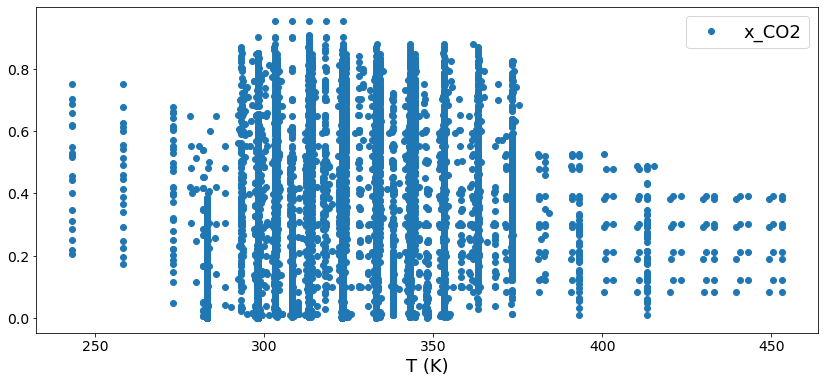

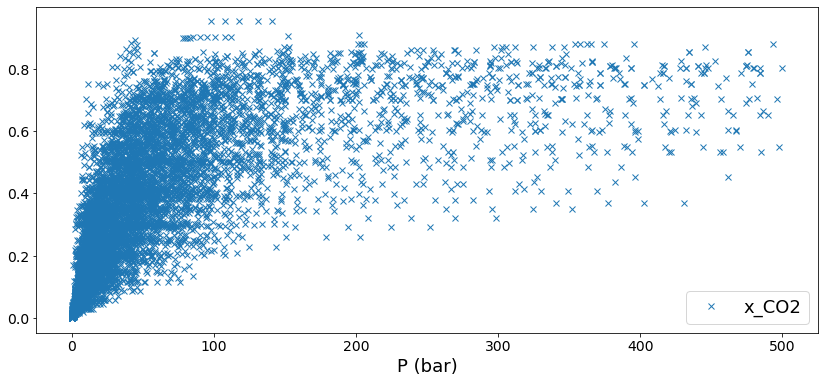

In [10]:
fig1=dataCO2.plot(x="T (K)", y=["x_CO2"],linestyle='', marker='o',fontsize=14)
fig2=dataCO2.plot(x="P (bar)", y=["x_CO2"],linestyle='', marker='x',fontsize=14)

### 2.2. Script 2

In [10]:
#######################################################################################
# separation of the data set into two subsets: (1) training of the ANN & (2) test of the ANN
# library used: pandas
data_train = dataCO2.sample(frac=0.8, axis=0, random_state=1)
data_test  = dataCO2.drop(data_train.index)

x_train = data_train.drop(['IL','cation','anion','x_CO2'],axis=1)
y_train = data_train['x_CO2']
x_test  = data_test.drop(['IL','cation','anion','x_CO2'],axis=1)
y_test  = data_test['x_CO2']
x_trainTmp = x_train.copy() # for plotting purpose
x_testTmp = x_test.copy()

display(x_train.describe().style.format("{0:.2f}").set_caption("Training set before normalization :"))

# using scikit-learn
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train.values)
xtrain_scaled = scaler.transform(x_train.values) #returns a numpy array
xtest_scaled = scaler.transform(x_test.values) #returns a numpy array
x_train = pd.DataFrame(xtrain_scaled, index=x_train.index, columns=x_train.columns)
x_test = pd.DataFrame(xtest_scaled, index=x_test.index, columns=x_test.columns)

display(x_train.describe().style.format("{0:.2f}").set_caption("Training set after normalization (with scikit-learn):"))
display(x_test.describe().style.format("{0:.2f}").set_caption("Test set after normalization (with scikit-learn):"))

#######################################################################################
# ANN: 1 input layer (53 neurons) / 2 hidden layers (20 and 7 neurons) / 1 output layer (1 neuron) 
# library used: keras

def defANN(shape,acthL):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name='iLayer'))
    model.add(keras.layers.Dense(7, activation=acthL, name='hLayer'))
    model.add(keras.layers.Dense(1, name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

acthL='tanh'
#acthL='relu'
if 'ANNmodel' in globals():
    del ANNmodel
if 'ANNhistory' in globals():
    del ANNhistory
ANNmodel=defANN( (53,), acthL )
ANNmodel.summary()

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,325.37,54.56,1.18,4.76,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.01,0.01,0.10,0.00,0.00,0.01,0.00,0.02,0.06,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.08,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,25.44,77.35,0.97,5.55,0.26,0.16,0.20,0.40,0.10,0.28,0.07,0.06,0.10,0.42,0.08,0.07,0.11,0.30,0.06,0.07,0.09,0.06,0.15,0.23,0.06,0.31,0.12,0.14,0.13,0.31,0.14,0.08,0.27,0.04,0.12,0.49,0.04,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.22,0.09,0.08,0.06,0.10,0.04,0.08,0.04,0.05
min,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,308.15,9.98,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,323.15,27.20,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,342.85,64.50,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00,8093.00
mean,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.23,-0.71,-1.21,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,-1.82,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
25%,-0.68,-0.58,-0.18,-0.32,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
50%,-0.09,-0.35,-0.18,-0.32,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
75%,0.69,0.13,-0.18,0.04,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,1.16,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
max,5.02,5.76,6.01,4.19,11.57,12.38,4.79,12.37,9.88,10.48,14.96,15.87,9.88,0.55,12.68,13.68,9.22,3.06,16.13,14.19,11.38,16.97,6.43,4.14,17.96,2.85,7.98,6.93,7.74,2.85,7.11,13.23,3.49,28.43,8.56,1.16,28.43,8.64,8.99,18.34,7.46,9.33,9.65,6.65,4.24,10.63,12.68,15.63,9.54,27.11,12.95,22.47,21.18


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00,2023.00
mean,-0.02,-0.02,0.00,-0.03,-0.02,0.01,0.01,-0.01,-0.01,-0.00,-0.02,-0.01,0.03,0.03,0.02,-0.04,-0.02,-0.03,-0.02,-0.01,0.00,0.00,0.04,-0.03,0.07,0.02,-0.00,0.05,-0.02,0.02,0.04,0.03,-0.03,0.01,-0.01,-0.03,-0.02,-0.00,0.01,-0.02,-0.00,-0.00,-0.01,0.02,0.05,-0.06,-0.02,-0.04,0.01,-0.02,-0.02,-0.02,-0.02
std,0.96,0.95,0.96,0.94,0.90,1.06,1.02,0.90,0.96,1.00,0.82,0.94,1.12,0.98,1.10,0.68,0.92,0.95,0.80,0.90,1.02,1.00,1.12,0.93,1.49,1.02,1.00,1.15,0.90,1.02,1.14,1.18,0.96,1.10,0.98,1.00,0.63,0.99,1.04,0.82,0.99,0.98,0.97,1.07,1.09,0.63,0.85,0.60,1.04,0.60,0.87,0.71,0.82
min,-3.23,-0.71,-1.21,-0.86,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,-1.82,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
25%,-0.70,-0.58,-0.18,-0.32,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
50%,-0.09,-0.38,-0.18,-0.32,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,-0.86,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
75%,0.51,0.14,-0.18,0.04,-0.09,-0.12,-0.21,-0.10,-0.10,-0.20,-0.07,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.33,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.14,-0.13,-0.35,-0.14,-0.08,-0.29,-0.04,-0.12,1.16,-0.04,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.10,-0.04,-0.08,-0.04,-0.05
max,5.02,5.73,6.01,4.19,11.57,12.38,4.79,12.37,9.88,10.48,14.96,15.87,9.88,0.55,12.68,13.68,9.22,3.06,16.13,14.19,11.38,16.97,6.43,4.14,17.96,2.85,7.98,6.93,7.74,2.85,7.11,13.23,3.49,28.43,8.56,1.16,28.43,8.64,8.99,18.34,7.46,9.33,9.65,6.65,4.24,10.63,12.68,15.63,9.54,27.11,12.95,22.47,21.18


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hLayer (Dense)               (None, 7)                 378       
_________________________________________________________________
oLayer (Dense)               (None, 1)                 8         
Total params: 386
Trainable params: 386
Non-trainable params: 0
_________________________________________________________________


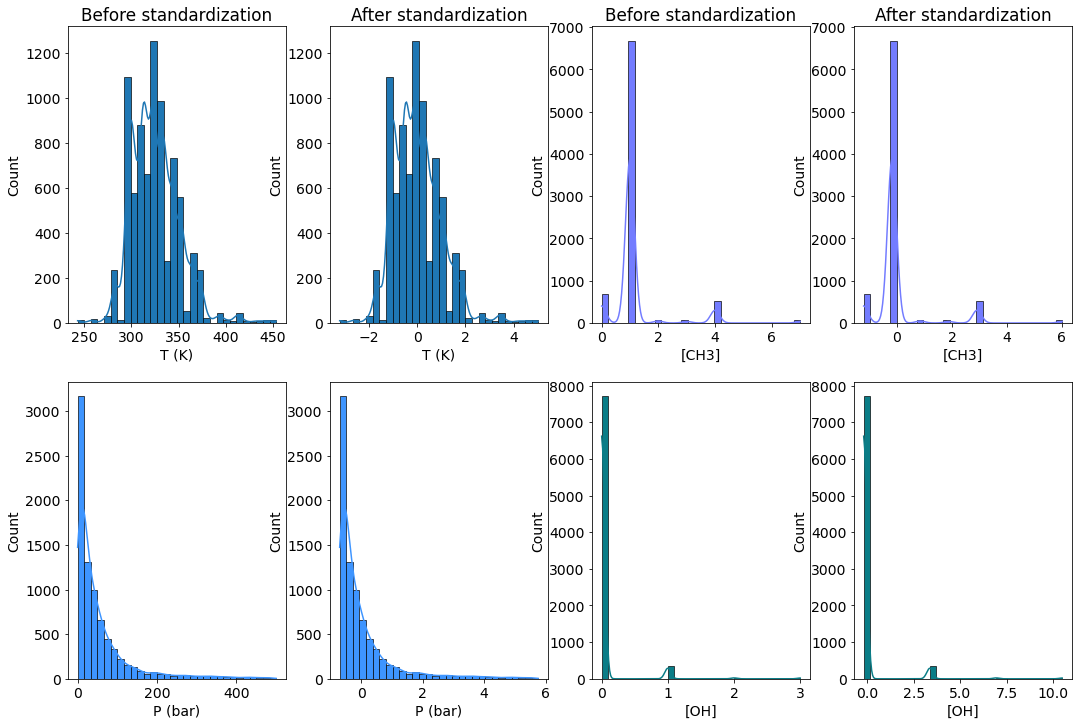

In [11]:
#######################################################################################
# graphic representation of the previous tables
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

nbins=30
fig = plt.figure(figsize=(18, 12))
plt.rcParams["font.size"] = (14) #font size
plt.tick_params(axis='x',labelsize = 16)
plt.tick_params(axis='y',labelsize = 12)
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

ax00=plt.subplot(gs[0,0], title="Before standardization")
fig00=sb.histplot(data=x_trainTmp,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax10=plt.subplot(gs[1,0])
fig10=sb.histplot(data=x_trainTmp,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)
ax01=plt.subplot(gs[0,1], title="After standardization")
fig01=sb.histplot(data=x_train,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax11=plt.subplot(gs[1,1])
fig11=sb.histplot(data=x_train,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)

ax02=plt.subplot(gs[0,2], title="Before standardization")
fig02=sb.histplot(data=x_trainTmp,x="[CH3]", bins=nbins, kde=True, color="#737cff", alpha=1.0)
ax12=plt.subplot(gs[1,2])
fig12=sb.histplot(data=x_trainTmp,x="[OH]", bins=nbins, kde=True, color="#0a7d87", alpha=1.0)
ax03=plt.subplot(gs[0,3], title="After standardization")
fig03=sb.histplot(data=x_train,x="[CH3]", bins=nbins, kde=True, color="#737cff", alpha=1.0)
ax13=plt.subplot(gs[1,3])
fig13=sb.histplot(data=x_train,x="[OH]", bins=nbins, kde=True, color="#0a7d87", alpha=1.0)

plt.savefig('./CO2-images/Standardization_CO2data.png',dpi=300,bbox_inches='tight')

#del xtrain_scaled, xtest_scaled
#del x_trainTmp, x_testTmp

In [12]:
#######################################################################################
# optimization of the ANN
# library used: keras

from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 200,
                    batch_size      = 25,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

#######################################################################################
# accuracy of the ANN?
# library used: numpy

ytrain_hat=ANNmodel.predict(x_train)
ytest_hat=ANNmodel.predict(x_test)
diffyt = ytrain_hat.ravel() - y_train.ravel()
diffyp = ytest_hat.ravel() - y_test.ravel()

print()
print("xCO2(predicted) - xCO2(actual)")
print(
      "Train.","mean: ", np.mean(diffyt),
      "   std: ", np.std(diffyt),
      "   MAE: ", np.average(abs(diffyt)),
      "    R2: ", np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1]
     )
print(
      "Test.","mean: ", np.mean(diffyp),
      "   std: ", np.std(diffyp),
      "   MAE: ", np.average(abs(diffyp)),
      "    R2: ", np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1]
     )

#######################################################################################
# save model for later use

#!mkdir -p saved_models
#ANNmodel.save('saved_models/ANNmodel-basic')

Epoch 1/200
324/324 [==============================] - 2s 3ms/step - loss: 0.3334 - mae: 0.3382 - mse: 0.3334 - val_loss: 0.0272 - val_mae: 0.1269 - val_mse: 0.0272
Epoch 2/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0220 - mae: 0.1139 - mse: 0.0220 - val_loss: 0.0168 - val_mae: 0.1022 - val_mse: 0.0168
Epoch 3/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0156 - mae: 0.0954 - mse: 0.0156 - val_loss: 0.0138 - val_mae: 0.0898 - val_mse: 0.0138
Epoch 4/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0132 - mae: 0.0871 - mse: 0.0132 - val_loss: 0.0116 - val_mae: 0.0818 - val_mse: 0.0116
Epoch 5/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0119 - mae: 0.0838 - mse: 0.0119 - val_loss: 0.0098 - val_mae: 0.0745 - val_mse: 0.0098
Epoch 6/200
324/324 [==============================] - 1s 2ms/step - loss: 0.0100 - mae: 0.0758 - mse: 0.0100 - val_loss: 0.0087 - val_mae: 0.0703 - val_mse: 0.0087
Epoch 7/20

<div class="warn">
    Once completed, jump to the <a href="#model-evaluation">Model Evaluation</a> section
</div>

### 2.x. Appendix: activation functions

In [96]:
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

z = np.linspace(-5, 5, 200)
pw=4
ph=4

#### Relu function

$$R(z)=\begin{cases}
\begin{array}{cc}
z & \,\,\,\,\,\,\,z>0\\
0 & \,\,\,\,\,\,\,z\leq0
\end{array}\end{cases}$$

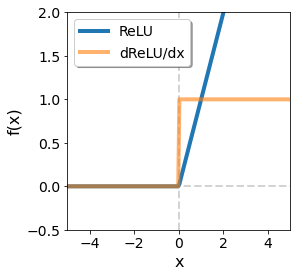

In [97]:
def relu(z):
    return np.maximum(0, z)

figR, axR = plt.subplots(1, 1)
figR.set_size_inches(pw,ph)
axR.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axR.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axR.plot(z, relu(z),linewidth=4,label="ReLU")
axR.plot(z, derivative(relu, z), linewidth=4, alpha=0.6, label="dReLU/dx")
axR.legend(loc='upper left', shadow=True, fontsize='14')
axR.set_xlabel('x',fontdict={'fontsize':16})
axR.set_ylabel('f(x)',fontdict={'fontsize':16})
axR.set_xlim(-5, 5)
axR.set_ylim(-0.5, 2)
axR.tick_params(labelsize = 14)
plt.show()


#### tanh function

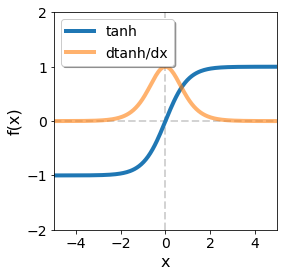

In [98]:
def tanh(z):
    return np.tanh(z)

figT, axT = plt.subplots(1, 1)
figT.set_size_inches(pw,ph)
axT.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axT.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axT.plot(z, tanh(z),linewidth=4,label="tanh")
axT.plot(z, derivative(tanh, z), linewidth=4, alpha=0.6, label="dtanh/dx")
axT.legend(loc='upper left', shadow=True, fontsize='14')
axT.set_xlabel('x',fontdict={'fontsize':16})
axT.set_ylabel('f(x)',fontdict={'fontsize':16})
axT.set_xlim(-5, 5)
axT.set_ylim(-2, 2)
axT.tick_params(labelsize = 14)
plt.show()


#### softmax function
$$\sigma_{i}(\boldsymbol{x})=\frac{e^{x_{i}}}{\sum_{j=1}^{K}e^{x_{j}}}$$

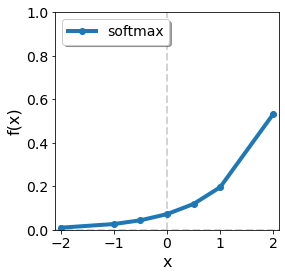

Sum of softmax values: 1.0


In [99]:
def softmax(x):
    e_x = np.exp(x - np.max(x)) #this implentation has a better numerical stability
    return e_x / e_x.sum()

z2 = [-2., -1., -0.5, 0., 0.5, 1., 2.]
figS, axS = plt.subplots(1, 1)
figS.set_size_inches(pw,ph)
axS.axhline(y=0, linewidth=2, linestyle='--', color='lightgray')
axS.axvline(x=0, linewidth=2, linestyle='--', color='lightgray')
axS.plot(z2, softmax(z2),linewidth=4,marker='o',label="softmax")
axS.legend(loc='upper left', shadow=True, fontsize='14')
axS.set_xlabel('x',fontdict={'fontsize':16})
axS.set_ylabel('f(x)',fontdict={'fontsize':16})
axS.set_xlim(-2.1, 2.1)
axS.set_ylim(0., 1.0)
axS.tick_params(labelsize = 14)
plt.show()
print(f"Sum of softmax values: {softmax(z2).sum()}")

## **3.** <a id="model-evaluation"></a>Model evaluation

### **3.1.** Loss, MAE and MSE as a function of epochs = during the ANN optimization with the back-propagation algorithm 

x_train / loss      : 0.0020
x_train / mae       : 0.0329
x_train / mse       : 0.0020

x_test / loss       : 0.0021
x_test / mae        : 0.0335
x_test / mse        : 0.0021


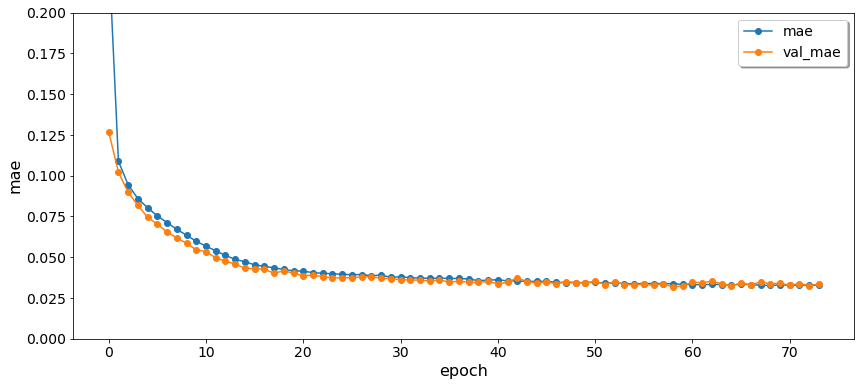

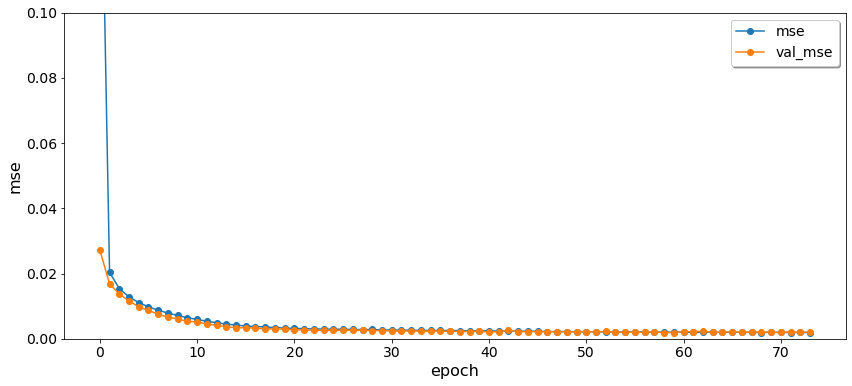

In [13]:
ANNscoreTrain= ANNmodel.evaluate(x_train, y_train, verbose=0)
print(f"{color.GREEN}x_train / loss      : {ANNscoreTrain[0]:5.4f}")
print(f"x_train / mae       : {ANNscoreTrain[1]:5.4f}")
print(f"x_train / mse       : {ANNscoreTrain[2]:5.4f}{color.OFF}")
print()
ANNscoreEval = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(f"{color.BLUE}x_test / loss       : {ANNscoreEval[0]:5.4f}")
print(f"x_test / mae        : {ANNscoreEval[1]:5.4f}")
print(f"x_test / mse        : {ANNscoreEval[2]:5.4f}{color.OFF}")

df=pd.DataFrame(data=ANNhistory.history)
plt.rcParams["figure.figsize"] = (14,6)
figMAE=df.plot(y=["mae","val_mae"],linestyle='-', marker='o',fontsize=14)
figMAE.set_xlabel('epoch',fontdict={'fontsize':16})
figMAE.set_ylabel('mae',fontdict={'fontsize':16})
figMAE.set_ylim([0.0,0.2])
figMAE.legend(loc='upper right', shadow=True, fontsize='14')
figMSE=df.plot(y=["mse","val_mse"],linestyle='-', marker='o',fontsize=14)
figMSE.set_xlabel('epoch',fontdict={'fontsize':16})
figMSE.set_ylabel('mse',fontdict={'fontsize':16})
figMSE.set_ylim([0.0,0.1])
figMSE.legend(loc='upper right', shadow=True, fontsize='14')

### **3.2.** Comparison between experimental and predicted CO<sub>2</sub> solubility

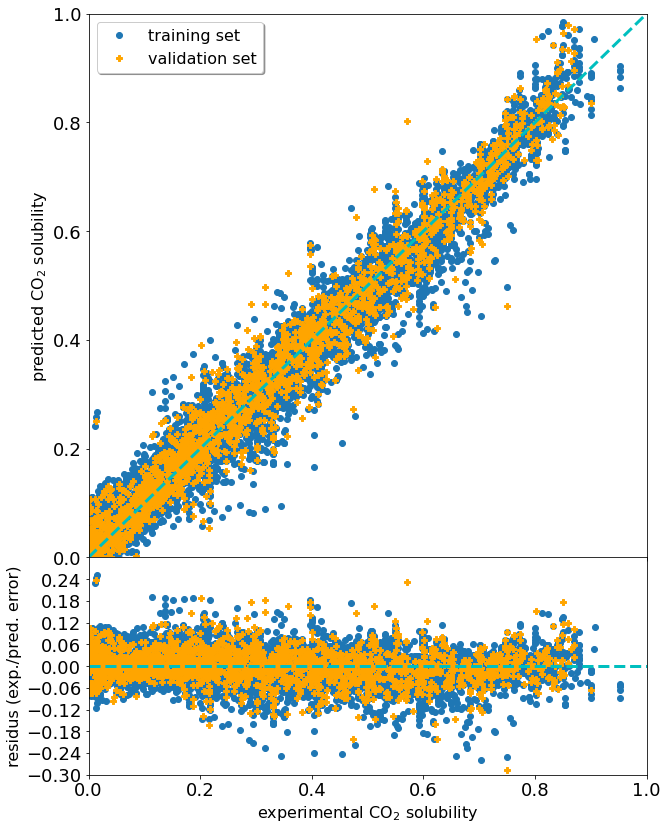

In [17]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

xD=[0,1]
yD=[0,1]
fig = plt.figure(figsize=(10, 14))
plt.rcParams["font.size"] = (18) #font size
plt.tick_params(labelsize = 14)
gs = gridspec.GridSpec(2, 1, height_ratios=[10, 4], hspace=0)
ax0=plt.subplot(gs[0])
ax0.plot(y_train,ytrain_hat,'o',color="#1f77b4",label='training set')
ax0.plot(y_test,ytest_hat,'P',color="orange",label='validation set')
ax0.plot(xD,yD,'c',linestyle='--',lw=3)
ax0.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
ax0.set_ylabel('predicted CO$_2$ solubility',fontsize=16)
ax0.set_xlim(0,1);ax0.set_ylim(0,1) 
ax0.legend(loc='upper left', shadow=True, fontsize='16')
plt.setp(ax0.get_xticklabels(), visible=False) #cosmetics

ax1=plt.subplot(gs[1])
ax1.plot(y_train,diffyt,'o',color="#1f77b4",label='training set')
ax1.plot(y_test,diffyp,'P',color="orange",label='validation set')
ax1.axhline(y=0, xmin=0., xmax=1.0, color='c', linestyle='--', linewidth=3)
ax1.set_xlabel('experimental CO$_2$ solubility',fontsize=16)
ax1.set_ylabel('residus (exp./pred. error)',fontsize=16)
ax1.set_xlim(0.0,1.0); ax1.set_ylim(-0.3,0.3)
ax1.axes.get_yaxis().set_major_locator(MaxNLocator(prune='upper'))  #cosmetics

plt.savefig('./CO2-images/predictionCO2.png',dpi=300,bbox_inches='tight')

### **3.3.** Residus plot as histograms (distribution of the error)

 Train. mean: -0.000    std: 0.044    MAE: 0.033     R2: 0.983
  Test. mean: 0.002    std: 0.045    MAE: 0.033     R2: 0.981


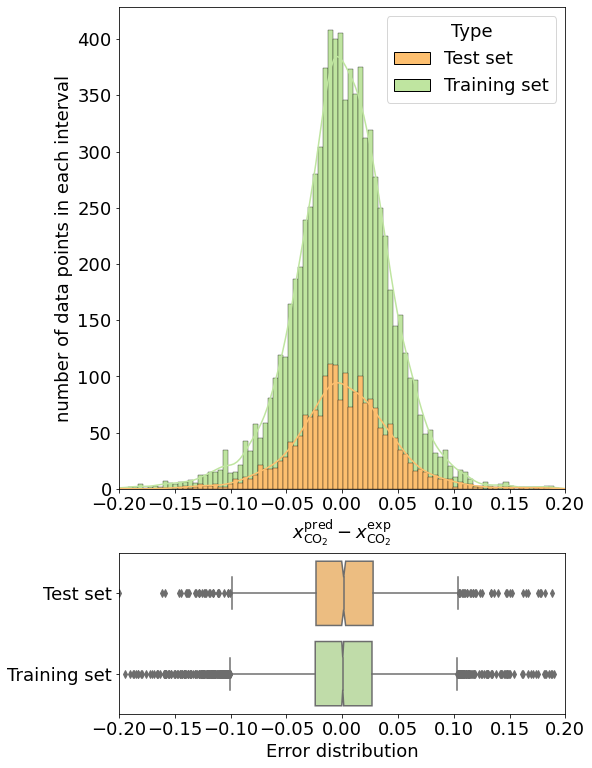

In [18]:
print(color.BLUE,
      "Train.","mean: {:.3f}".format(np.mean(diffyt)),
      "   std: {:.3f}".format(np.std(diffyt)),
      "   MAE: {:.3f}".format(np.average(abs(diffyt))),
      "    R2: {:.3f}".format(np.corrcoef(y_train.ravel(),ytrain_hat.ravel())[0,1])
     )
print(color.GREEN,
      " Test.","mean: {:.3f}".format(np.mean(diffyp)),
      "   std: {:.3f}".format(np.std(diffyp)),
      "   MAE: {:.3f}".format(np.average(abs(diffyp))),
      "    R2: {:.3f}".format(np.corrcoef(y_test.ravel(),ytest_hat.ravel())[0,1])
     )

# make a dataframe
df1 = pd.DataFrame(
    {
        "Error distribution": diffyp,
        "Type": 'Test set'    },
)
#display(df1)
df2 = pd.DataFrame(
    {
        "Error distribution": diffyt,
        "Type": 'Training set'    },
)
#display(df2)
distrib=pd.concat([df1,df2],ignore_index=True)
#display(distrib)

xlim=0.2
nbins=120

import matplotlib.gridspec as gridspec
plt.rcParams["figure.figsize"] = (8,13) #graphic size
plt.rcParams["font.size"] = (18) #font size
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
plt.subplot(gs[0])
fig1=sb.histplot(data=distrib,x="Error distribution", hue="Type", bins=nbins, kde=True, palette='Spectral', alpha=1.0)
plt.xlabel("$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$")
plt.ylabel("number of data points in each interval")
plt.xlim(-xlim,xlim)
plt.subplot(gs[1])
plt.xlim(-xlim,xlim)
fig2=sb.boxplot(data=distrib, x="Error distribution", y="Type", notch=True, orient = 'h',palette='Spectral')
fig2.set(ylabel=None)
plt.savefig('./CO2-images/errorCO2.png',dpi=300,bbox_inches='tight')

In [19]:
vID.end()

**End at:** Friday 17 June 2022, 17:31:00  
**Duration:** 00:05:48 283ms

<p style="text-align: center"><img width="800px" src="./svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>